In [63]:
import pandas as pd
import numpy as np
import locale
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

from checkup_res import checkup_res

warnings.filterwarnings("ignore")
locale.setlocale(locale.LC_TIME,'')
pd.options.plotting.backend = "plotly"

In [64]:
ts = pd.read_pickle("orders.pkl")['2021-01-04':'2021-10-10']

In [65]:
ts.plot(title=f'Nb. de commandes par jour de {ts.index[0].strftime("%d-%m-%Y")} au {ts.index[-1].strftime("%d-%m-%Y")}')

La série décrit le nombre de commandes livrées par jour du 02 janvier 2020 au 15 octobre 2021 soit jours. On observe une forte saisonalité sur les jours de la semaine. Une modélisation par un modèle SARIMA peut être envisagé.

In [66]:
weekdays = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
ts.groupby(ts.index.strftime("%A")).mean().reindex(weekdays).plot(title="Nb. moyen de commandes par jour")

Cependant, il est clair que la série n'est pas stationnaire car :
- il semble y avoir une tendance légèrement à la hausse.
- la série ne semble pas avoir une variance constante au cours du temps.

On tente dans un premier temps une décomposition classique :
$$ X_t = m_t + S_t + Z_t $$
tel que $m_t$ et $S_t$ sont déterministes et représentent respectivment une tendance et une composante 7-périodique. $Z_t$ est quand à lui un terme de fluctuation dont on souhaiterai qu'il contienne des dépendances.

In [67]:
decomp = seasonal_decompose(ts.n_orders, model='additive')
decomp.trend.plot()

In [68]:
decomp.resid.plot()

In [69]:
y = decomp.resid.dropna()

# ADF Test
result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# KPSS Test
result = kpss(y, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Ljung-Box Test
result = sm.stats.acorr_ljungbox(decomp.resid.dropna().values, lags=[30], return_df=False)
print('\nLjung-Box Statistic: %f' % result[0][0])
print('p-value: %f' % result[1][0])

ADF Statistic: -8.838788006261417
p-value: 1.6905240925166546e-14

KPSS Statistic: 0.020582
p-value: 0.100000

Ljung-Box Statistic: 1005.557188
p-value: 0.000000


No handles with labels found to put in legend.


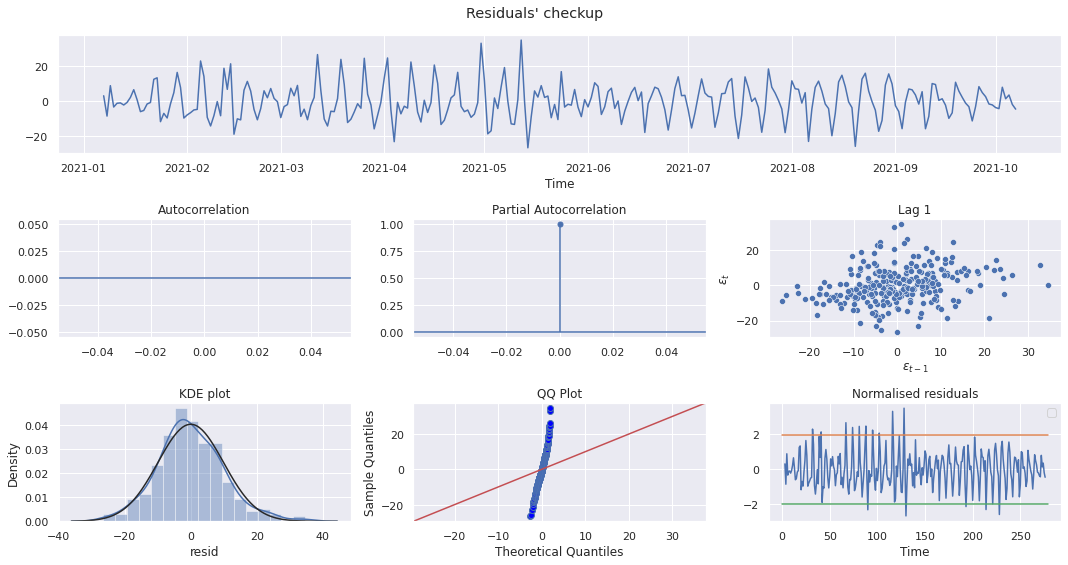

In [71]:
from checkup_res import checkup_res
checkup_res(decomp.resid)

In [73]:
ts["log_n_orders"] = ts.n_orders
ts["log_n_orders"][ts.n_orders==0] = 1
ts["log_n_orders"] = np.log(ts.log_n_orders)
ts.plot()

In [74]:
decomp_log = decomp = seasonal_decompose(ts.log_n_orders, model='additive')
decomp_log.resid.plot()

No handles with labels found to put in legend.


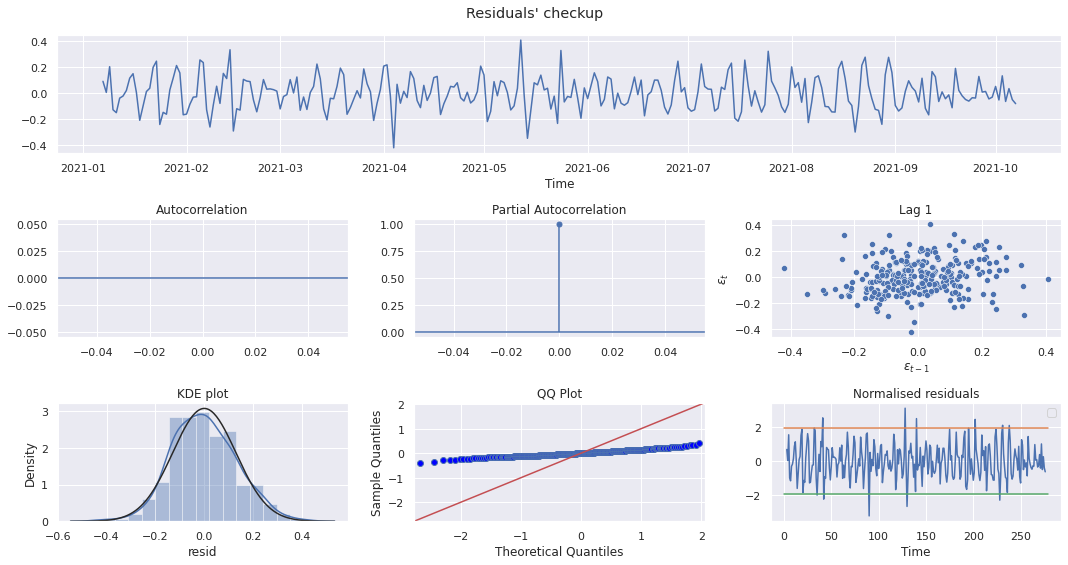

In [75]:
checkup_res(decomp_log.resid)

On observe une forte réduction de la variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated.

Regarding other possible uses of Box-Cox in the case of a series of iid random variables that do not appear to be normally distributed there may be a particular value of lambda that makes the data look approximately normal.

Presumably this could be applied in regression or time series to the error term.

maxlog=-0.7083349855859683


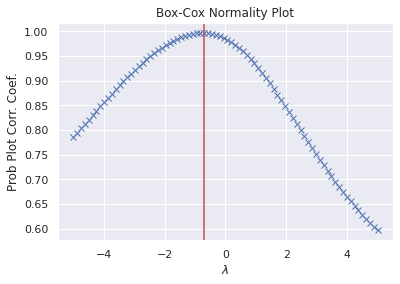

In [77]:
from scipy.stats import boxcox, boxcox_normplot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
prob = boxcox_normplot(ts.n_orders, -5, 5, plot=ax)
_, maxlog = boxcox(ts.n_orders)
ax.axvline(maxlog, color='r')
print(f"{maxlog=}")

In [82]:
ts["boxcox_n_orders"] = boxcox(ts.n_orders, lmbda=maxlog)
ts.plot()

In [84]:
decomp_boxcox = seasonal_decompose(ts.boxcox_n_orders, model='additive')
decomp_boxcox.resid.plot()

No handles with labels found to put in legend.


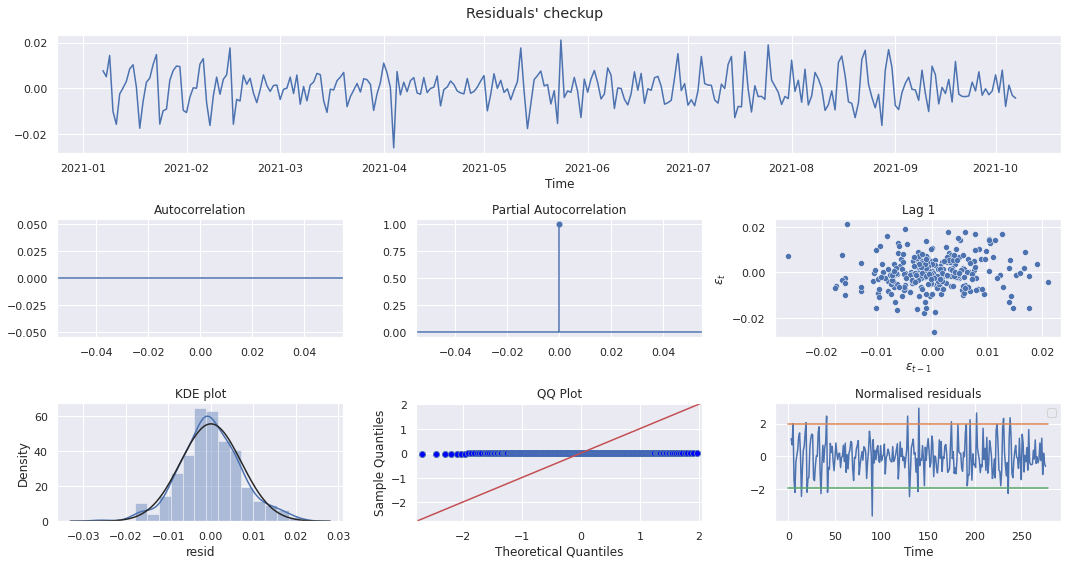

In [85]:
checkup_res(decomp_boxcox.resid)

In [ ]:
import pmdarima as pm
model = pm.auto_arima(ts.boxcox_n_orders, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())